In [50]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

queries = {}
queries['green0'] = '(Cat=="Green" | Cat=="Fringe") & Distance_from_hole<5'
queries['green5'] = '(Cat=="Green" | Cat=="Fringe") & Distance_from_hole>=5 & Distance_from_hole<10'
queries['green10'] = '(Cat=="Green" | Cat=="Fringe") & Distance_from_hole>=10 & Distance_from_hole<20'
queries['green20'] = '(Cat=="Green" | Cat=="Fringe") & Distance_from_hole>=20'
queries['rough0'] = '(Cat=="Primary Rough" | Cat=="Intermediate Rough") & Distance_from_hole<90'
queries['rough90'] = '(Cat=="Primary Rough" | Cat=="Intermediate Rough") & Distance_from_hole>=90 & Distance_from_hole<375'
queries['rough375'] = '(Cat=="Primary Rough" | Cat=="Intermediate Rough") & Distance_from_hole>=375'
queries['fairway0'] = 'Cat=="Fairway" & Distance_from_hole<300'
queries['fairway300'] = 'Cat=="Fairway" & Distance_from_hole>=300 & Distance_from_hole<540'
queries['fairway540'] = 'Cat=="Fairway" & Distance_from_hole>=540'
queries['bunker'] = 'Cat=="Bunker"'
queries['tee3'] = 'Cat=="Tee Box" & Par_Value==3'
queries['tee45'] = 'Cat=="Tee Box" & (Par_Value==4 | Par_Value==5)'
queries['other'] = 'Cat=="Other"'

cols = ('Year','Permanent_Tournament_#')
data = pd.concat([pd.read_csv('../data/%d.csv' % year,usecols=cols) for year in range(2003,2018)])

cols = ('Year','Permanent_Tournament_#')
rawdata = pd.concat([pd.read_csv('../data/rawdata/hole/%d.txt' % year, sep=';', 
                                 usecols=lambda x: x.strip().replace(' ','_') in cols)
                     for year in range(2003,2018)])
tourn_order = rawdata.drop_duplicates().values.tolist()

data.columns = [col.replace('#','') for col in data.columns]
tourns_in_data = data[['Year','Permanent_Tournament_']].drop_duplicates().values.tolist()
tourns_in_data = set(tuple(tup) for tup in tourns_in_data)
tourn_order = [tup for tup in tourn_order if tuple(tup) in tourns_in_data]
tourn_seq = {tuple(tup):u for u,tup in enumerate(tourn_order)}

ratings, reps = {},{}

In [24]:
data = pd.read_csv('../data/2003.csv',nrows=1)

In [25]:
data.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1.1', u'Tour_Code',
       u'Tour_Description', u'Year', u'Tourn.#', u'Player_#', u'Course_#',
       u'Permanent_Tournament_#', u'Player_First_Name', u'Player_Last_Name',
       u'Round', u'Tournament_Name', u'Course_Name', u'Hole', u'Hole_Score',
       u'Par_Value', u'Yardage', u'Shot', u'Shot_Type(S/P/D)', u'#_of_Strokes',
       u'From_Location(Scorer)', u'From_Location(Enhanced)',
       u'To_Location(Laser)', u'To_Location(Enhanced)', u'Distance',
       u'Distance_to_Pin', u'In_the_Hole_Flag', u'Around_the_Green_Flag',
       u'1st_Putt_Flag', u'Distance_to_Hole_after_the_Shot', u'Time', u'Lie',
       u'Elevation', u'Slope', u'End_X_Coordinate', u'End_Y_Coordinate',
       u'End_Z_Coordinate', u'Distance_from_Center', u'Distance_from_Edge',
       u'Date', u'Penalty_Shots', u'start_loc_equal_to_prev_start_loc',
       u'Start_X_Coordinate', u'Start_Y_Coordinate', u'Start_Z_Coordinate',
       u'Real_Shots', u'last_shot_mask',

In [26]:
cols_with_hashtags = [col for col in data.columns if '#' in col]

In [27]:
cols_with_hashtags

['Tourn.#', 'Player_#', 'Course_#', 'Permanent_Tournament_#', '#_of_Strokes']

In [34]:
e_d,e_t,w_d,a,beta = '0.8','0.7','0.8','0.85','8'
for cat in cats:
    ratings[cat] = np.load('../ranks/ranks-%s-%s-%s-%s-%s/%s_ranks.npy' % (e_d,e_t,w_d,a,beta,cat))
    reps[cat] = np.load('../ranks/ranks-%s-%s-%s-%s-%s/%s_reps.npy' % (e_d,e_t,w_d,a,beta,cat))

data = pd.read_csv('../data/%d.csv' % (2003,))
cols_with_hashtags = [col for col in data.columns if '#' in col]
data = data.rename(columns={col:col.replace('#','') for col in cols_with_hashtags})
data['tourn_num'] = [tourn_seq[tuple(tup)] for tup in data[['Year','Permanent_Tournament_']].values]
to_c_stack = []
for cat in cats:
    mask = np.zeros(len(data))
    mask[data.query(queries[cat]).index.values] = 1
    to_c_stack.append(mask)
cat_dummies = np.column_stack(to_c_stack)
assert (cat_dummies.sum(1)==1).mean()==1
cat_map = {u:cat for u,cat in enumerate(cats)}
data['baby_cat'] = [cat_map[i] for i in cat_dummies.argmax(1)]
data = data.rename(columns={col.replace('#',''):col for col in cols_with_hashtags})

In [35]:
data = data.drop([col for col in data.columns if col.startswith('Unnamed')],axis=1)

In [41]:
with open('../PickleFiles/num_to_ind_shot.pkl','rb') as pickle_file:
    num_to_ind = pickle.load(pickle_file)
data.insert(5,'Player_Index',[num_to_ind[num] for num in data['Player_#']])

In [45]:
data['skill_estimate'] = [ratings[baby_cat][player_ind,tourn_num-1]
                          if tourn_num>0 else np.nan
                          for baby_cat,player_ind,tourn_num in zip(data['baby_cat'],
                                                                   data['Player_Index'],
                                                                   data['tourn_num'])]

In [53]:
data['observation_count'] = [reps[baby_cat][player_ind,tourn_num-1]
                             if tourn_num>0 else np.nan
                             for baby_cat,player_ind,tourn_num in zip(data['baby_cat'],
                                                                      data['Player_Index'],
                                                                      data['tourn_num'])]

In [47]:
data['skill_estimate'].describe()

count    1.075192e+06
mean     1.000057e+00
std      6.537673e-02
min      2.642141e-02
25%      9.760821e-01
50%      1.001376e+00
75%      1.026717e+00
max      2.440782e+00
Name: skill_estimate, dtype: float64

In [48]:
data['skill_estimate'].isnull().sum()

17142

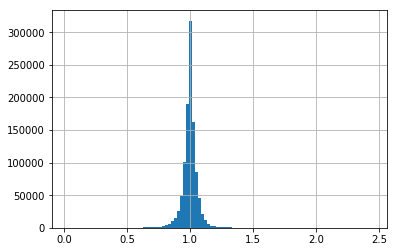

In [52]:
data['skill_estimate'].dropna().hist(bins=100)

In [54]:
data['observation_count'].isnull().sum()

4996

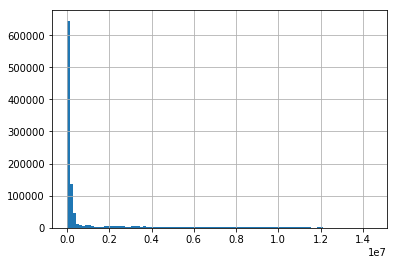

In [55]:
data['observation_count'].dropna().hist(bins=100)